In [ ]:
!pip install -q pyspark

from pyspark.sql import SparkSession
import os
import sys
from pyspark.mllib.recommendation import MatrixFactorizationModel
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import concat_ws,col

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

from pyspark import SparkConf
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [ ]:
from pyspark.ml.classification import LogisticRegression
# please download 'ratings.csv' from week 12 on canvas
spark = SparkSession.builder.appName('recommend-ML').getOrCreate()

In [ ]:
df = spark.read.csv('ratings_supervised_1211.csv', header = True, inferSchema = True)
cols = df.columns
df=df.withColumn('AlbumID',df['AlbumID'].cast("float").alias('AlbumID'))
df=df.withColumn('ArtistID',df['ArtistID'].cast("float").alias('ArtistID'))
df.printSchema()

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

numericCols = ['AlbumID', 'ArtistID', 'Genre1ID', 'Genre1ID', 'Genre2ID', 'Genre3ID', 'AlbumRatin', 'ArtistRating', 'Genre1Rating', 'Genre2Rating', 'Genre3Rating', 'MinScore', 'MaxScore', 'MeanScore', 'VarScore']
stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

label_stringIdx = StringIndexer(inputCol = 'Truth', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- TrackID: string (nullable = true)
 |-- UserID: double (nullable = true)
 |-- ItemID: double (nullable = true)
 |-- AlbumID: float (nullable = true)
 |-- ArtistID: float (nullable = true)
 |-- Genre1ID: double (nullable = true)
 |-- Genre2ID: double (nullable = true)
 |-- Genre3ID: double (nullable = true)
 |-- AlbumRatin: double (nullable = true)
 |-- ArtistRating: double (nullable = true)
 |-- Genre1Rating: double (nullable = true)
 |-- Genre2Rating: double (nullable = true)
 |-- Genre3Rating: double (nullable = true)
 |-- MinScore: double (nullable = true)
 |-- MaxScore: double (nullable = true)
 |-- MeanScore: double (nullable = true)
 |-- VarScore: double (nullable = true)
 |-- Truth: double (nullable = true)



In [ ]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[192723.0, 132319.0, 131552.0, 131552.0, 17346...","[223220.0, 233697.0, 131552.0, 131552.0, 17346...","(0.0, 0.0, 131552.0, 131552.0, 173467.0, 11047...","[220103.0, 113265.0, 131552.0, 131552.0, 17346...","[43738.0, 173170.0, 131552.0, 131552.0, 173467..."
TrackID,200031_30877,200031_8244,200031_130183,200031_198762,200031_34503
UserID,200031.0,200031.0,200031.0,200031.0,200031.0
ItemID,30877.0,8244.0,130183.0,198762.0,34503.0
AlbumID,192723.0,223220.0,0.0,220103.0,43738.0
ArtistID,132319.0,233697.0,0.0,113265.0,173170.0
Genre1ID,131552.0,131552.0,131552.0,131552.0,131552.0
Genre2ID,173467.0,173467.0,173467.0,173467.0,173467.0
Genre3ID,110478.0,110478.0,110478.0,110478.0,110478.0


In [ ]:
# below is the typical random split 
# of the train and test data sets
# HOWEVER, our testing users have 6 tracks for each
# We cannot use random split here
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4260
Test Dataset Count: 1740


In [ ]:
# we split the last 76 users X 6 tracks = 468 records as the training 
# the first 50 users X 6 tracks = 300 records as the testing  
train = df.where(col("UserID").between(200596, 201720))
test = df.where(col("UserID").between(200031, 200563))
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 468
Test Dataset Count: 300


In [ ]:
# logistic regression in pySpark
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

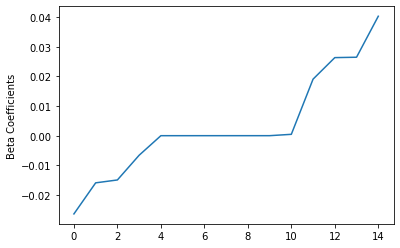

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

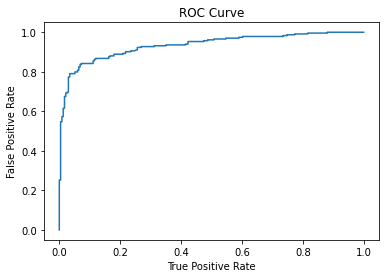

Training set areaUnderROC: 0.9338976550515007
+--------+--------+-----+--------------------+--------------------+----------+
|  UserID|  ItemID|label|         probability|       rawPrediction|prediction|
+--------+--------+-----+--------------------+--------------------+----------+
|200031.0| 30877.0|  1.0|[0.01477833356950...|[-4.1997044977705...|       1.0|
|200031.0|  8244.0|  1.0|[0.06875974904135...|[-2.6058987701384...|       1.0|
|200031.0|130183.0|  0.0|[0.76044919415140...|[1.15514377628472...|       0.0|
|200031.0|198762.0|  0.0|[0.64992822580319...|[0.61872373235811...|       0.0|
|200031.0| 34503.0|  1.0|[0.00991716594437...|[-4.6035214210034...|       1.0|
|200031.0|227283.0|  0.0|[0.16689593109041...|[-1.6077881159837...|       1.0|
|200032.0|218377.0|  0.0|[0.89657885249912...|[2.15977678266831...|       0.0|
|200032.0|110262.0|  0.0|[0.87281090971204...|[1.92604405505952...|       0.0|
|200032.0| 18681.0|  1.0|[9.38267975543692...|[-6.9705362531217...|       1.0|
|20003

In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

predictions = lrModel.transform(test)
predictions.select('UserID', 'ItemID', 'label', 'probability', 
                   'rawPrediction', 'prediction' ).show(12)


from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions,
{evaluator.metricName: "areaUnderROC"})))

In [ ]:
# col("userID").asc() sort the user ascending
# col("probability").desc() sort the probability descending (from large to small)
from pyspark.sql.functions import col
sort_predictions = predictions.select('UserID', 'TrackID', 
                                      'label', 'probability', 
                                      'rawPrediction', 'prediction' 
                                     ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions.show(6)

# probability column is where you can decide 
# the 3 tracks with highest "probability" for "1" and 
# the 3 tracks with lowest "probability" for "0" 
# tracks "198762", "34503", "130183" with "1"
# tracks "30877", "8244", "227283" with "0"
sort_predictions.show(6)

+--------+-------------+-----+--------------------+--------------------+----------+
|  UserID|      TrackID|label|         probability|       rawPrediction|prediction|
+--------+-------------+-----+--------------------+--------------------+----------+
|200031.0|200031_130183|  0.0|[0.76044919415140...|[1.15514377628472...|       0.0|
|200031.0|200031_198762|  0.0|[0.64992822580319...|[0.61872373235811...|       0.0|
|200031.0|200031_227283|  0.0|[0.16689593109041...|[-1.6077881159837...|       1.0|
|200031.0|  200031_8244|  1.0|[0.06875974904135...|[-2.6058987701384...|       1.0|
|200031.0| 200031_30877|  1.0|[0.01477833356950...|[-4.1997044977705...|       1.0|
|200031.0| 200031_34503|  1.0|[0.00991716594437...|[-4.6035214210034...|       1.0|
+--------+-------------+-----+--------------------+--------------------+----------+
only showing top 6 rows

+--------+-------------+-----+--------------------+--------------------+----------+
|  UserID|      TrackID|label|         probability|

In [ ]:
# decision tree classifier in pySpark
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
sort_predictions = predictions.select('UserID', 'TrackID', 
                   'label', 'probability', 
                   'rawPrediction', 'prediction' ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions.show(6)


from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions,
{evaluator.metricName: "areaUnderROC"})))

+--------+-------------+-----+--------------------+-------------+----------+
|  UserID|      TrackID|label|         probability|rawPrediction|prediction|
+--------+-------------+-----+--------------------+-------------+----------+
|200031.0|200031_198762|  0.0|           [1.0,0.0]|    [4.0,0.0]|       0.0|
|200031.0|200031_130183|  0.0|[0.85714285714285...|   [12.0,2.0]|       0.0|
|200031.0|  200031_8244|  1.0|           [0.0,1.0]|   [0.0,12.0]|       1.0|
|200031.0| 200031_30877|  1.0|           [0.0,1.0]|  [0.0,102.0]|       1.0|
|200031.0| 200031_34503|  1.0|           [0.0,1.0]|  [0.0,102.0]|       1.0|
|200031.0|200031_227283|  0.0|           [0.0,1.0]|    [0.0,3.0]|       1.0|
+--------+-------------+-----+--------------------+-------------+----------+
only showing top 6 rows

Test Area Under ROC: 0.8021333333333334


In [ ]:
# random forest classifier in pySpark
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=10)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
sort_predictions = predictions.select('UserID', 'TrackID', 
                   'label', 'probability', 
                   'rawPrediction', 'prediction' ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions.show(6)

+--------+-------------+-----+--------------------+--------------------+----------+
|  UserID|      TrackID|label|         probability|       rawPrediction|prediction|
+--------+-------------+-----+--------------------+--------------------+----------+
|200031.0|200031_130183|  0.0|[0.76060114821935...|[15.2120229643871...|       0.0|
|200031.0|200031_198762|  0.0|[0.39875,0.601250...|      [7.975,12.025]|       1.0|
|200031.0|200031_227283|  0.0|       [0.375,0.625]|          [7.5,12.5]|       1.0|
|200031.0|  200031_8244|  1.0|           [0.3,0.7]|          [6.0,14.0]|       1.0|
|200031.0| 200031_34503|  1.0|[0.10040650406504...|[2.00813008130081...|       1.0|
|200031.0| 200031_30877|  1.0|[0.05040650406504...|[1.00813008130081...|       1.0|
+--------+-------------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
# Gradient-Boosted Tree Classifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbt = GBTClassifier(maxIter=50)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
sort_predictions = predictions.select('UserID', 'TrackID', 
                   'label', 'probability', 
                   'rawPrediction', 'prediction' ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions.show(6)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions,
{evaluator.metricName: "areaUnderROC"})))

+--------+-------------+-----+--------------------+--------------------+----------+
|  UserID|      TrackID|label|         probability|       rawPrediction|prediction|
+--------+-------------+-----+--------------------+--------------------+----------+
|200031.0|200031_130183|  0.0|[0.70381798288601...|[0.43277279383656...|       0.0|
|200031.0|200031_198762|  0.0|[0.55282397914277...|[0.10604367467136...|       0.0|
|200031.0|  200031_8244|  1.0|[0.21361913611495...|[-0.6516232715459...|       1.0|
|200031.0|200031_227283|  0.0|[0.20747280664880...|[-0.6701132698759...|       1.0|
|200031.0| 200031_34503|  1.0|[0.05220363640229...|[-1.4494937587538...|       1.0|
|200031.0| 200031_30877|  1.0|[0.05064341560348...|[-1.4654876256335...|       1.0|
+--------+-------------+-----+--------------------+--------------------+----------+
only showing top 6 rows

Test Area Under ROC: 0.8398666666666664


In [ ]:
spark = SparkSession.builder.appName('recommend-ML').getOrCreate()

df_unsuper = spark.read.csv('ratings_unsupervised_1211.csv', header = True, inferSchema = True)
df_unsuper_lr = df_unsuper
cols_unsuper = df_unsuper.columns
df_unsuper=df_unsuper.withColumn('AlbumID',df_unsuper['AlbumID'].cast("float").alias('AlbumID'))
df_unsuper=df_unsuper.withColumn('ArtistID',df_unsuper['ArtistID'].cast("float").alias('ArtistID'))
df_unsuper.printSchema()

numericCols_unsuper = ['AlbumID', 'ArtistID', 'Genre1ID', 'Genre1ID', 'Genre2ID', 'Genre3ID', 'AlbumRating', 'ArtistRating', 'Genre1Rating', 'Genre2Rating', 'Genre3Rating', 'MinScore', 'MaxScore', 'MeanScore', 'VarScore']
stages_unsuper = []
assemblerInputs_unsuper =  numericCols_unsuper
assembler_unsuper = VectorAssembler(inputCols=assemblerInputs_unsuper, outputCol="features")
stages_unsuper += [assembler_unsuper]

#label_stringIdx_unsuper = StringIndexer(inputCol = 'AlbumID', outputCol = 'label')
#stages_unsuper += [label_stringIdx_unsuper]

pipeline = Pipeline(stages = stages_unsuper)
pipelineModel = pipeline.fit(df_unsuper)
df_unsuper = pipelineModel.transform(df_unsuper)
selectedCols = ['features'] + cols_unsuper
df_unsuper = df_unsuper.select(selectedCols)
df_unsuper.printSchema()

pd.DataFrame(df_unsuper.take(3), columns=df_unsuper.columns).transpose()

root
 |-- TrackID: string (nullable = true)
 |-- UserID: double (nullable = true)
 |-- ItemID: double (nullable = true)
 |-- AlbumID: float (nullable = true)
 |-- ArtistID: float (nullable = true)
 |-- Genre1ID: double (nullable = true)
 |-- Genre2ID: double (nullable = true)
 |-- Genre3ID: double (nullable = true)
 |-- AlbumRating: double (nullable = true)
 |-- ArtistRating: double (nullable = true)
 |-- Genre1Rating: double (nullable = true)
 |-- Genre2Rating: double (nullable = true)
 |-- Genre3Rating: double (nullable = true)
 |-- MinScore: double (nullable = true)
 |-- MaxScore: double (nullable = true)
 |-- MeanScore: double (nullable = true)
 |-- VarScore: double (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- TrackID: string (nullable = true)
 |-- UserID: double (nullable = true)
 |-- ItemID: double (nullable = true)
 |-- AlbumID: float (nullable = true)
 |-- ArtistID: float (nullable = true)
 |-- Genre1ID: double (nullable = true)
 |-- Genre2ID: double (nu

,0,1,2
features,"(209288.0, 0.0, 131552.0, 131552.0, 173467.0, ...","[277282.0, 271146.0, 131552.0, 131552.0, 17346...","(0.0, 0.0, 131552.0, 131552.0, 173467.0, 48505..."
TrackID,199810_208019,199810_74139,199810_9903
UserID,199810.0,199810.0,199810.0
ItemID,208019.0,74139.0,9903.0
AlbumID,209288.0,277282.0,0.0
ArtistID,0.0,271146.0,0.0
Genre1ID,131552.0,131552.0,131552.0
Genre2ID,173467.0,173467.0,173467.0
Genre3ID,48505.0,48505.0,48505.0
AlbumRating,0.0,0.0,0.0


In [ ]:
predictions_unsuper = gbtModel.transform(df_unsuper)

sort_predictions_unsuper = predictions_unsuper.select('UserID', 'TrackID', 
                   'probability', 
                   'rawPrediction', 'prediction' ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions_unsuper.show(7)

col_headers = ['TrackID', 'Predictor']
data2 = sort_predictions_unsuper.select(col("TrackID"),col("prediction"),col("rawPrediction"),col('probability'))
print(data2.show(3))
data2 = data2.withColumnRenamed("prediction", "Predictor")
print(data2.show(3))

#export and then postprocess in python to even out the 1s and 0s based on raw prediction
data2.toPandas().to_csv('unsupervised_gbtModel.csv', index=False)

+--------+-------------+--------------------+--------------------+----------+
|  UserID|      TrackID|         probability|       rawPrediction|prediction|
+--------+-------------+--------------------+--------------------+----------+
|199810.0| 199810_74139|[0.95468147893785...|[1.52383097626952...|       0.0|
|199810.0|199810_242681|[0.84057547023600...|[0.83125804913352...|       0.0|
|199810.0|  199810_9903|[0.69519290650487...|[0.41225513710205...|       0.0|
|199810.0|199810_208019|[0.66725122308396...|[0.34788941986044...|       0.0|
|199810.0|199810_105760|[0.08976802194303...|[-1.1582353395807...|       1.0|
|199810.0| 199810_18515|[0.02616166770254...|[-1.8084750159719...|       1.0|
|199812.0|199812_211361|[0.96944384656952...|[1.72857823303039...|       0.0|
+--------+-------------+--------------------+--------------------+----------+
only showing top 7 rows

+-------------+----------+--------------------+--------------------+
|      TrackID|prediction|       rawPrediction| 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [ ]:
predictions_unsuper = rfModel.transform(df_unsuper)

sort_predictions_unsuper = predictions_unsuper.select('UserID', 'TrackID', 
                   'probability', 
                   'rawPrediction', 'prediction' ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions.show(7)

col_headers = ['TrackID', 'Predictor']
data2 = sort_predictions_unsuper.select(col("TrackID"),col("prediction"),col("rawPrediction"),col('probability'))
data2 = data2.withColumnRenamed("prediction", "Predictor")

#export and then postprocess in python to even out the 1s and 0s based on raw prediction
data2.toPandas().to_csv('unsupervised_rfModel.csv', index=False)

+--------+-------------+-----+--------------------+--------------------+----------+
|  UserID|      TrackID|label|         probability|       rawPrediction|prediction|
+--------+-------------+-----+--------------------+--------------------+----------+
|200031.0|200031_130183|  0.0|[0.70381798288601...|[0.43277279383656...|       0.0|
|200031.0|200031_198762|  0.0|[0.55282397914277...|[0.10604367467136...|       0.0|
|200031.0|  200031_8244|  1.0|[0.21361913611495...|[-0.6516232715459...|       1.0|
|200031.0|200031_227283|  0.0|[0.20747280664880...|[-0.6701132698759...|       1.0|
|200031.0| 200031_34503|  1.0|[0.05220363640229...|[-1.4494937587538...|       1.0|
|200031.0| 200031_30877|  1.0|[0.05064341560348...|[-1.4654876256335...|       1.0|
|200032.0|200032_110262|  0.0|[0.94832196946858...|[1.45483066249950...|       0.0|
+--------+-------------+-----+--------------------+--------------------+----------+
only showing top 7 rows



/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [ ]:
predictions_unsuper = dtModel.transform(df_unsuper)

sort_predictions_unsuper = predictions_unsuper.select('UserID', 'TrackID', 
                   'probability', 
                   'rawPrediction', 'prediction' ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions.show(7)

col_headers = ['TrackID', 'Predictor']
data2 = sort_predictions_unsuper.select(col("TrackID"),col("prediction"),col("rawPrediction"),col('probability'))
data2 = data2.withColumnRenamed("prediction", "Predictor")

#export and then postprocess in python to even out the 1s and 0s based on raw prediction
data2.toPandas().to_csv('unsupervised_dtModel.csv', index=False)

+--------+-------------+-----+--------------------+--------------------+----------+
|  UserID|      TrackID|label|         probability|       rawPrediction|prediction|
+--------+-------------+-----+--------------------+--------------------+----------+
|200031.0|200031_130183|  0.0|[0.70381798288601...|[0.43277279383656...|       0.0|
|200031.0|200031_198762|  0.0|[0.55282397914277...|[0.10604367467136...|       0.0|
|200031.0|  200031_8244|  1.0|[0.21361913611495...|[-0.6516232715459...|       1.0|
|200031.0|200031_227283|  0.0|[0.20747280664880...|[-0.6701132698759...|       1.0|
|200031.0| 200031_34503|  1.0|[0.05220363640229...|[-1.4494937587538...|       1.0|
|200031.0| 200031_30877|  1.0|[0.05064341560348...|[-1.4654876256335...|       1.0|
|200032.0|200032_110262|  0.0|[0.94832196946858...|[1.45483066249950...|       0.0|
+--------+-------------+-----+--------------------+--------------------+----------+
only showing top 7 rows



/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [ ]:
predictions_unsuper = lrModel.transform(df_unsuper)

sort_predictions_unsuper = predictions_unsuper.select('UserID', 'TrackID', 
                                      'probability', 
                                      'rawPrediction', 'prediction' 
                                     ).sort(col("UserID").asc(), col("probability").desc())
sort_predictions_unsuper.show(7)

col_headers = ['TrackID', 'Predictor']
data2 = sort_predictions_unsuper.select(col("TrackID"),col("prediction"),col("rawPrediction"),col('probability'))
data2 = data2.withColumnRenamed("prediction", "Predictor")

#export and then postprocess in python to even out the 1s and 0s based on raw prediction
data2.toPandas().to_csv('unsupervised_lrModel.csv', index=False)

+--------+-------------+--------------------+--------------------+----------+
|  UserID|      TrackID|         probability|       rawPrediction|prediction|
+--------+-------------+--------------------+--------------------+----------+
|199810.0|199810_242681|[0.92531145484411...|[2.51680365303174...|       0.0|
|199810.0|199810_208019|[0.87423843922669...|[1.93896541287602...|       0.0|
|199810.0| 199810_74139|[0.83518420851630...|[1.62282387452731...|       0.0|
|199810.0|  199810_9903|[0.77225894245369...|[1.22111064044289...|       0.0|
|199810.0| 199810_18515|[0.09973023030824...|[-2.2002256187832...|       1.0|
|199810.0|199810_105760|[0.08782915048456...|[-2.3404338519116...|       1.0|
|199812.0|199812_276940|[0.93854375998723...|[2.72600410548644...|       0.0|
+--------+-------------+--------------------+--------------------+----------+
only showing top 7 rows



/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
